In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from astropy.time import Time
import warnings

from matplotlib.ticker import MultipleLocator

In [21]:
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'b': '#1f77b4',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3',
    'darkgrey': '0.2',
    'palegrey': '0.6'
}

In [22]:
print('NumPy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))

NumPy version: 1.22.4
pandas version: 1.4.2
matplotlib version: 3.5.2


In [23]:
# SN metadata


class SN_meta:
    def __init__(self, name, z, tmax, ebv, files, IR_thres=1.1e4):
        self.name = name
        self.z = z
        self.t_max_mjd = tmax - 2400000.5
        self.ebv = ebv
        files = np.sort(files)
        self.NIRfiles = files[[(np.loadtxt(spec)[-1, 0] > IR_thres)
                               for spec in files]]
        self.NIRfiles = self.NIRfiles[[
            not ('GNIRS_v' in spec) for spec in self.NIRfiles
        ]]
        self.OPTfiles = files[[(np.loadtxt(spec)[-1, 0] < IR_thres)
                               for spec in files]]
        print(self.NIRfiles)


jgb = SN_meta('SN\ 2020jgb',
              z=0.0307,
              tmax=2458986.91,
              ebv=0.404,
              files=glob.glob('./SN2020jgb/*ascii'))
byg = SN_meta('SN\ 2018byg',
              z=0.066,
              tmax=2458258.99,
              ebv=0.032,
              files=glob.glob('./SN2018byg/ZTF18aaqeasu*ascii'))
hnk = SN_meta('SN\ 2016hnk',
              z=0.0161,
              tmax=2457689.98,
              ebv=0.0224,
              files=glob.glob('./SN2016hnk/*dat'))
fe = SN_meta('SN\ 2011fe',
             z=0.000804,
             tmax=2455814.27,
             ebv=0.008,
             files=glob.glob('./SN2011fe/*dat'))
da = SN_meta('SN\ 2004da',
             z=0.015881,
             tmax=2453189.7,
             ebv=0.109,
             files=glob.glob('./SN2004da/*flm'))
hn = SN_meta('SN\ 2012hn',
             z=0.0076,
             tmax=2456034.5,
             ebv=0.087,
             files=glob.glob('./SN2012hn/*'))

['./SN2020jgb/ZTF20aayhacx_20200609_Gemini-N_v1.ascii']
['./SN2018byg/ZTF18aaqeasu_20180603_Keck1_v1.ascii']
['./SN2016hnk/2016hnk_2016-11-04_01-57-23.700_Gemini-S_Flamingos-2_PESSTO.dat'
 './SN2016hnk/2016hnk_2016-11-06_02-05-03.429_ESO-NTT_Sofi_PESSTO.dat']
['./SN2011fe/SN2011fe_2011-08-28_04-05-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-08-31_06-00-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-03_09-07-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-07_08-53-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-10_09-22-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-13_16-05-00_HST_STIS_HST-Ia.dat']
[]
['./SN2012hn/2012hn_2012-05-11_00-00-00_VLT-UT2_X-Shooter_PESSTO.ascii']


In [24]:
def plot_box_spec(wave, flux):
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave) / 2
    wv_plot = np.append(
        wave[0] - (wave[1] - wave[0]) / 2,
        np.append(np.repeat(wv_plot[0:-1], 2),
                  wave[-1] + (wave[-1] - wave[-2]) / 2))

    return wv_plot, flux_plot

5.0
15.0
19.0
25.0
Try the observation date.
Try the observation date.
Try the observation date.
Try the observation date.
Try the observation date.
Try the observation date.
Try the observation date.
Try the observation date.
Try the observation date.


/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94292/1727735222.py:30: RuntimeWarning: invalid value encountered in log10
  np.log10(fl / norm_flux) - h * spec_num_norm[num],
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94292/1727735222.py:30: RuntimeWarning: invalid value encountered in log10
  np.log10(fl / norm_flux) - h * spec_num_norm[num],
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94292/1727735222.py:97: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


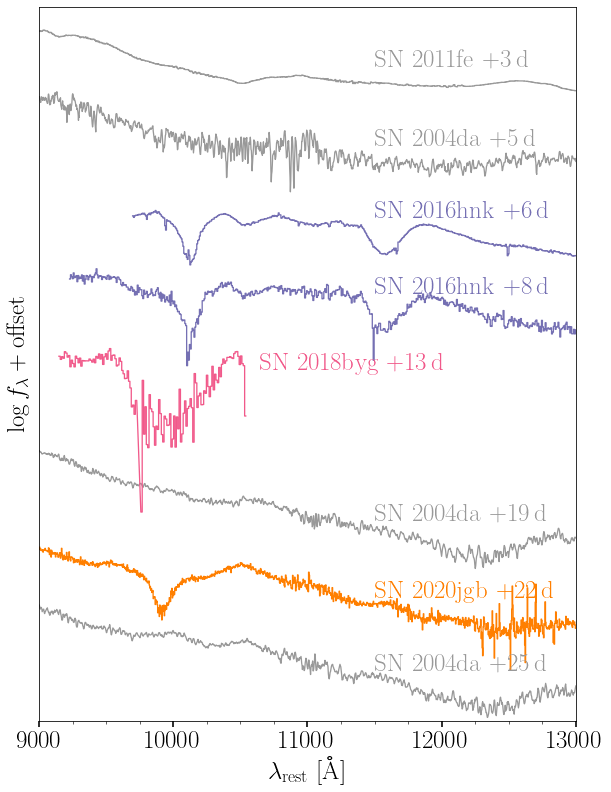

In [29]:
rv = 3.1

fig, ax = plt.subplots(figsize=(8, 11))

h = .8
v = 11500

normIa = glob.glob('./NIR_Marion09/*04da*')
normIa.sort()

spec_num_norm = [1, 5, 6, 8]
num = -1
for spec in normIa: #normal Ia from Marion+09
    with open(spec) as f:
        ll = f.readlines()
    for l in ll:
        if 'Phase' in l:
            phase = float(l.split('=')[1].split("d")[0])
            print(phase)
    num += 1
    if num == 1:
        continue
    spec_df = pd.read_csv(spec,
                          comment='#',
                          delim_whitespace=True,
                          header=None)
    wv, fl = spec_df[1].values * 1e4, spec_df[2].values
    norm_flux = np.nanmedian(fl[np.where((wv > 10300) & (wv < 10500))])
    ax.plot(wv,
            np.log10(fl / norm_flux) - h * spec_num_norm[num],
            color=color_map['palegrey'],
            linewidth=1.3)
    if phase < 0:
        ax.text(min(v, wv[-1] * 1.01),
                .1 * h - h * 1.05 * spec_num_norm[num],
                r'$\mathrm{SN\ 2004da}$' + ' $-{:.0f}\,\mathrm d$'.format(np.abs(phase)),
                color=color_map['palegrey'])
    else:
        ax.text(min(v, wv[-1] * 1.01),
                .1 * h - h * 1.06 * spec_num_norm[num],
                r'$\mathrm{SN\ 2004da}$' + ' $+{:.0f}\,\mathrm d$'.format(np.abs(phase)),
                color=color_map['palegrey'])

spec_num = [0, 2, 3, 4, 7, 9]
num = -1
for sn, c in zip([fe, hnk, byg, jgb], ['palegrey', 'purple', 'magenta', 'orange', 'green']):
    for spec in sn.NIRfiles:
        spec_df = pd.read_csv(spec,
                              comment='#',
                              delim_whitespace=True,
                              header=None)

        with open(spec) as f:
            ll = f.readlines()
        # brute force
        mjd_found = False
        for l in ll:
            if 'MJD' in l:
                mjd_found = True
                if '=' in l and 'at start' in l:
                    mjd_obs = float(l.split('=')[1].split("'")[1])
                elif '=' in l and '/' in l:
                    mjd_obs = float(l.split('=')[1].split('/')[0])
                elif '=' in l:
                    mjd_obs = float(l.split('=')[1])
                elif ':' in l:
                    mjd_obs = float(l.split(':')[1])
                break
        if not mjd_found:
            print('Warning: MJD-obs not found in {}!'.format(spec))
            print('Try the observation date.')
            year = '_20'
            pos_dat = spec.find(str(year)) + 1
            try:
                year_obs = spec[pos_dat:pos_dat + 4]
                mon_obs = spec[pos_dat + 4:pos_dat + 6]
                date_obs = spec[pos_dat + 6:pos_dat + 8]
                mjd_obs = Time('{}-{}-{}'.format(year_obs, mon_obs,
                                                 date_obs)).mjd
            except:
                mjd_obs = Time(spec[pos_dat:pos_dat + 10]).mjd

        phase = (mjd_obs - sn.t_max_mjd) / (1 + sn.z)
        if phase < 1:
            continue
        num += 1

        try:
            if 'Keck' in spec:
                fl_unc = spec_df[3].values
            else:
                fl_unc = spec_df[2].values

                if 'P60' in spec or 'P200' in spec:
                    fl_unc **= .5
        except:
            warnings.warn("No flux uncertainty in the datafile!")
            # set relative uncertainty to be 10%
            fl_unc = np.ones_like(spec_df[0].values) * 1e-1 * np.median(
                spec_df[0].values)
        fl_unc0 = fl_unc.copy()

        wv0, fl0 = spec_df[0].values, spec_df[1].values,
        E0 = 10**(0.4 * calALambda(wv0, rv, sn.ebv))
        fl0 = fl0 * E0

        if sn == byg:
            out = data_binning(np.array(
                [spec_df[0].values, spec_df[1].values, fl_unc]).T,
                               size=10)
        else:
            out = data_binning(np.array(
                [spec_df[0].values, spec_df[1].values, fl_unc]).T,
                               size=.1)
        wv, fl = plot_box_spec(out[:, 0], out[:, 1])
        wv, fl = wv[fl > 1e-2 * np.nanmedian(fl)], fl[fl > 1e-2 * np.nanmedian(fl)]

        fl_unc = np.repeat(out[:, -1], 2)

        E = 10**(0.4 * calALambda(wv, rv, sn.ebv))
        fl = fl * E

        norm_flux = np.nanmedian(fl[np.where((wv / (1 + sn.z) > 10300)
                                             & (wv / (1 + sn.z) < 11000))])
        '''ax.plot(wv0 / (1 + sn.z),
                np.log10(fl0 / norm_flux) - h * spec_num[num],
                color=color_map[c],
                linewidth=1,
                alpha=0.2)'''
        ax.plot(wv / (1 + sn.z),
                np.log10(fl / norm_flux) - h * spec_num[num] ,
                color=color_map[c],
                linewidth=1.3)
        if mjd_obs - sn.t_max_mjd < 24:
            ax.text(min(v, wv[-1] / (1 + sn.z) * 1.01),
                    .15 * h - 1.07 * h * spec_num[num],
                    r'$\mathrm{' + sn.name + '}$' +
                    ' $+{:.0f}\,\mathrm d$'.format(np.abs(phase)),
                    color=color_map[c])
        else:
            ax.text(min(v, wv[-1] / (1 + sn.z) * 1.01),
                    .15 * h - 1.15 * h * spec_num[num],
                    r'$\mathrm{' + sn.name + '}$' +
                    ' $+{:.0f}\,\mathrm d$'.format(np.abs(phase)),
                    color=color_map[c])

ax.set_xlim(9000, 13000)
ax.set_ylim(-1.01 * h * (spec_num_norm[-1] + 1), h)
ax.set_ylabel(r'$\log f_\lambda + \mathrm{offset}$')
ax.set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$',
              **{'fontname': 'Times New Roman'})
ax.xaxis.set_minor_locator(MultipleLocator(250))
ax.set_yticks([])

fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
fig.savefig('../paper/figures/NIR_spec_comp.pdf', bbox_inches='tight')

In [26]:
from scipy.interpolate import splrep, splev

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94292/2762223662.py:135: RuntimeWarning: divide by zero encountered in log10
  np.log10(fl0 / norm_flux) - h * spec_num[num],
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94292/2762223662.py:135: RuntimeWarning: invalid value encountered in log10
  np.log10(fl0 / norm_flux) - h * spec_num[num],
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94292/2762223662.py:140: RuntimeWarning: invalid value encountered in log10
  np.log10(fl / norm_flux) - h * spec_num[num],
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94292/2762223662.py:135: RuntimeWarning: divide by zero encountered in log10
  np.log10(fl0 / norm_flux) - h * spec_num[num],
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94292/2762223662.py:135: RuntimeWarning: invalid value encountered in log10
  np.log10(fl0 / norm_flux) - h * spec_num[num],
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94292/2762223662.py:

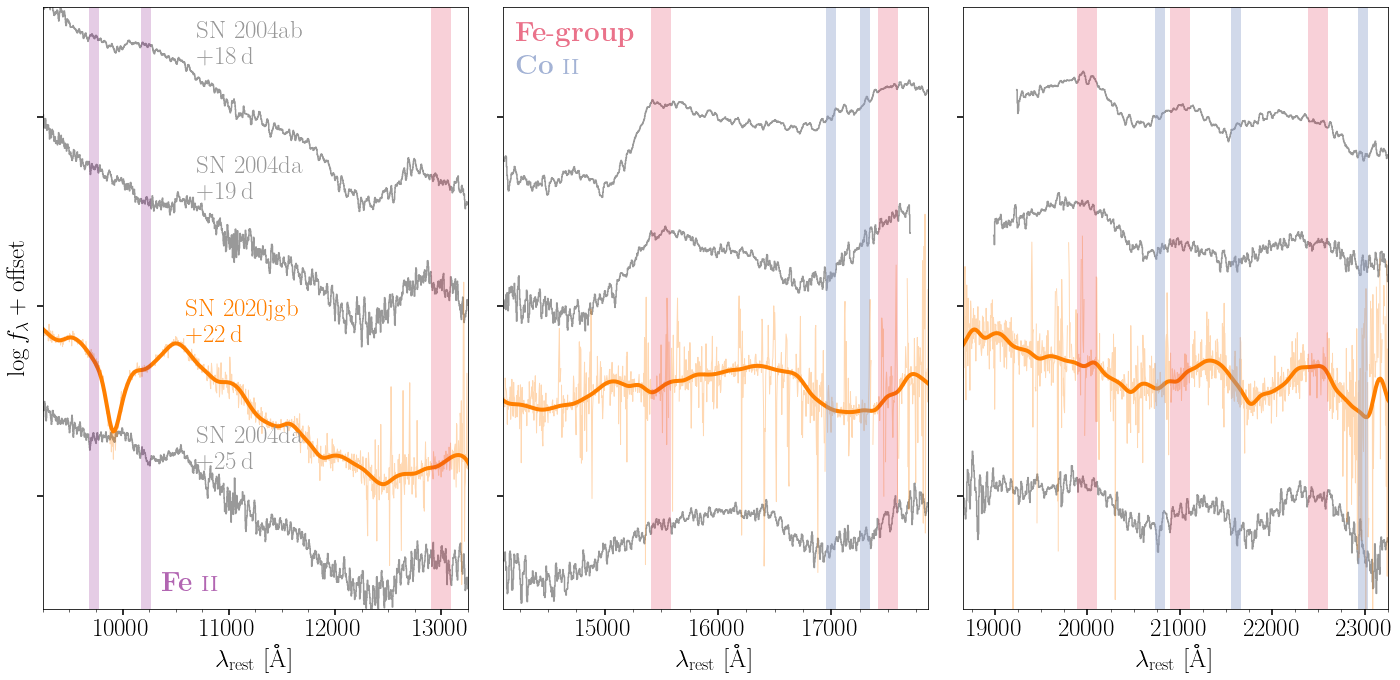

In [27]:
rv = 3.1

fig, Ax = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

h = 0.7
V = [9350, 16000, 20000]
ran = [[9250, 13250], [14100, 17850], [18650, 23250]]

normIas = [
    glob.glob('./NIR_Marion09/*04da*'),
    glob.glob('./NIR_Marion09/*04ab*')
]
for k in range(3):
    ax = Ax[k]
    v = V[k]

    spec_num = [[1, 3], [0]]
    names = [r'$\mathrm{SN\ 2004da}$', r'$\mathrm{SN\ 2004ab}$']
    for normIa, spec_num_norm, name in zip(normIas, spec_num, names):
        normIa.sort()
        num = -1
        for spec in normIa:
            with open(spec) as f:
                ll = f.readlines()
            for l in ll:
                if 'Phase' in l:
                    phase = float(l.split('=')[1].split("d")[0])
            if phase < 17:
                continue
            num += 1
            spec_df = pd.read_csv(spec,
                                  comment='#',
                                  delim_whitespace=True,
                                  header=None)
            wv0, fl0 = spec_df[1].values * 1e4, spec_df[2].values
            fl0, wv0 = fl0[wv0 > ran[k][0]][2:], wv0[wv0 > ran[k][0]][2:]
            fl0, wv0 = fl0[wv0 < ran[k][-1]], wv0[wv0 < ran[k][-1]]
            wv, fl = plot_box_spec(wv0, fl0)

            norm_flux = np.nanmedian(fl[np.abs(wv - np.mean(ran[k])) < 500])
            ax.plot(wv,
                    np.log10(fl / norm_flux) - h * spec_num_norm[num],
                    color=color_map['palegrey'],
                    linewidth=1.5)
            if phase < 0:
                Phase = ' $-{:.0f}\,\mathrm d$'.format(np.abs(phase))
            else:
                Phase = ' $+{:.0f}\,\mathrm d$'.format(np.abs(phase))
            if k == 0:
                ax.text(10700,
                        .6 * h - h * 1.02 * spec_num_norm[num],
                        name,
                        color=color_map['palegrey'])
                ax.text(10700,
                        .4 * h - h * 1.02 * spec_num_norm[num],
                        Phase,
                        color=color_map['palegrey'],
                        ha='left')

    spec_num = [2]
    num = -1
    for sn, c in zip([jgb], ['orange']):
        for spec in sn.NIRfiles:
            spec_df = pd.read_csv(spec,
                                  comment='#',
                                  delim_whitespace=True,
                                  header=None)

            with open(spec) as f:
                ll = f.readlines()
            # brute force
            mjd_found = False
            for l in ll:
                if 'MJD' in l:
                    mjd_found = True
                    if '=' in l and 'at start' in l:
                        mjd_obs = float(l.split('=')[1].split("'")[1])
                    elif '=' in l and '/' in l:
                        mjd_obs = float(l.split('=')[1].split('/')[0])
                    elif '=' in l:
                        mjd_obs = float(l.split('=')[1])
                    elif ':' in l:
                        mjd_obs = float(l.split(':')[1])
                    break
            if not mjd_found:
                print('Warning: MJD-obs not found in {}!'.format(spec))
                print('Try the observation date.')
                year = '_20'
                pos_dat = spec.find(str(year)) + 1
                try:
                    year_obs = spec[pos_dat:pos_dat + 4]
                    mon_obs = spec[pos_dat + 4:pos_dat + 6]
                    date_obs = spec[pos_dat + 6:pos_dat + 8]
                    mjd_obs = Time('{}-{}-{}'.format(year_obs, mon_obs,
                                                     date_obs)).mjd
                except:
                    mjd_obs = Time(spec[pos_dat:pos_dat + 10]).mjd

            phase = (mjd_obs - sn.t_max_mjd) / (1 + sn.z)
            if phase < 1:
                continue
            num += 1

            try:
                if 'Keck' in spec:
                    fl_unc = spec_df[3].values
                else:
                    fl_unc = spec_df[2].values

                    if 'P60' in spec or 'P200' in spec:
                        fl_unc **= .5
            except:
                warnings.warn("No flux uncertainty in the datafile!")
                # set relative uncertainty to be 10%
                fl_unc = np.ones_like(spec_df[0].values) * 1e-1 * np.median(
                    spec_df[0].values)
            fl_unc0 = fl_unc.copy()

            wv0, fl0 = spec_df[0].values, spec_df[1].values,
            E0 = 10**(0.4 * calALambda(wv0, rv, sn.ebv))
            fl0 = fl0 * E0

            out = data_binning(np.array(
                [spec_df[0].values, spec_df[1].values, fl_unc]).T,
                               size=100)
            spl = splrep(out[:, 0], out[:, 1], w=out[:, 2]**-2)
            wv = np.linspace(out[0, 0], out[-1, 0], 1000)
            fl = splev(wv, spl)

            E = 10**(0.4 * calALambda(wv, rv, sn.ebv))
            fl = fl * E

            norm_flux = np.nanmedian(fl[np.abs(wv - np.mean(ran[k])) < 500])
            ax.plot(wv0 / (1 + sn.z),
                    np.log10(fl0 / norm_flux) - h * spec_num[num],
                    color=color_map[c],
                    linewidth=1,
                    alpha=0.3)
            ax.plot(wv / (1 + sn.z),
                    np.log10(fl / norm_flux) - h * spec_num[num],
                    color=color_map[c],
                    linewidth=4)
            if phase < 0:
                Phase = ' $-{:.0f}\,\mathrm d$'.format(np.abs(phase))
            else:
                Phase = ' $+{:.0f}\,\mathrm d$'.format(np.abs(phase))
            if k == 0:
                ax.text(10600,
                        .5 * h - 1.0 * h * spec_num[num],
                        r'$\mathrm{' + sn.name + '}$',
                        color=color_map[c])
                ax.text(10600,
                        .3 * h - 1.0 * h * spec_num[num],
                        Phase,
                        color=color_map[c],
                        ha='left')

    ax.set_xlim(ran[k])
    ax.set_ylim(-h * 4 + 0.2, h * .9 - 0.05)
    ax.set_yticklabels([])
    ax.set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$',
                  **{'fontname': 'Times New Roman'})
    ax.xaxis.set_minor_locator(MultipleLocator(250))
    ax.yaxis.set_major_locator(MultipleLocator(1))

Ax[0].set_ylabel(r'$\log f_\lambda + \mathrm{offset}$')

# Fe-group
for wv in [13000, 15500, 17500, 20000, 21000, 22500]:
    if wv < ran[0][1]:
        ax = Ax[0]
    elif wv < ran[1][1]:
        ax = Ax[1]
    else:
        ax = Ax[2]
    ax.axvline(wv, linewidth=20, color='crimson', alpha=0.2)
Ax[1].text(ran[1][0] + 120,
           0.4,
           r'$\mathbf{Fe}$-$\mathbf{group}$',
           color='crimson',
           fontsize=28,
           alpha=.6)

# Co ii
for wv in [17462, 17772, 21350, 22205, 23613]:
    if wv < ran[0][1]:
        ax = Ax[0]
    elif wv < ran[1][1]:
        ax = Ax[1]
    else:
        ax = Ax[2]
    ax.axvline(wv * (1 - 8 / 300), linewidth=10, color=color_map['blue'], alpha=0.4)
Ax[1].text(ran[1][0] + 120,
           0.23,
           r'$\mathbf{Co\ \textsc{ii}}$',
           color=color_map['blue'],
           fontsize=28,
           alpha=.8)

# Fe ii
for wv in [10500, 9998]:
    if wv < ran[0][1]:
        ax = Ax[0]
    elif wv < ran[1][1]:
        ax = Ax[1]
    else:
        ax = Ax[2]
    ax.axvline(wv * (1 - 8 / 300), linewidth=10, color='purple', alpha=0.2)
Ax[0].text(ran[0][0] + 1120,
           -2.5,
           r'$\mathbf{Fe\ \textsc{ii}}$',
           color='purple',
           fontsize=28,
           alpha=.6)

#plt.show()
fig.subplots_adjust(left=0, bottom=0, top=1, right=1)
fig.tight_layout()
fig.savefig('../paper/figures/NIR_spec.pdf', bbox_inches='tight')